Copyright 2021 Google LLC.
SPDX-License-Identifier: Apache-2.0

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

# **Socratic Models: Image Captioning**

Socratic Models (SMs) is a framework that composes multiple pre-existing foundation models (e.g., large language models, visual language models, audio-language models) to provide results for new multimodal tasks, without any model finetuning.

This colab runs an example of SMs for image captioning.

This is a reference implementation of one task demonstrated in the work: [Socratic Models: Composing Zero-Shot Multimodal Reasoning with Language](https://socraticmodels.github.io/)

**Disclaimer:** this colab uses CLIP and GPT-3 as foundation models, and may be subject to unwanted biases. This code should be used with caution (and checked for correctness) in downstream applications.

### **Quick Start:**

**Step 1.** Register for an [OpenAI API key](https://openai.com/blog/openai-api/) to use GPT-3 (there's a free trial) and enter it below

**Step 2.** Menu > Change runtime type > Hardware accelerator > "GPU"

**Step 3.** Menu > Runtime > Run all



In [1]:
openai_api_key = "your-api-key"

## **Setup**
This installs a few dependencies: PyTorch, CLIP, GPT-3.

In [2]:
!pip install ftfy regex tqdm fvcore imageio imageio-ffmpeg openai pattern
!pip install git+https://github.com/openai/CLIP.git
!pip install -U --no-cache-dir gdown --pre
!pip install profanity-filter
!nvidia-smi  # Show GPU info.

     |████████████████████████████████| 53 kB 833 kB/s 
     |████████████████████████████████| 50 kB 3.5 MB/s 
     |████████████████████████████████| 26.9 MB 7.5 MB/s 
     |████████████████████████████████| 41 kB 203 kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 22.2 MB 1.7 MB/s 
     |████████████████████████████████| 596 kB 28.6 MB/s 
     |████████████████████████████████| 162 kB 48.9 MB/s 
     |████████████████████████████████| 87 kB 6.7 MB/s 
     |████████████████████████████████| 81 kB 9.8 MB/s 
     |████████████████████████████████| 5.6 MB 35.2 MB/s 
     |████████████████████████████████| 5.6 MB 38.0 MB/s 
     |████████████████████████████████| 419 kB 47.6 MB/s 
     |████████████████████████████████| 104 kB 50.6 MB/s 
     |████████████████████████████████| 3.6 MB 38.9 MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.5.post20220305-py3-none-

In [3]:
import datetime
import json
import os
import re
import time

import requests
import clip
import cv2
import matplotlib.pyplot as plt
import numpy as np
import openai
from PIL import Image
from profanity_filter import ProfanityFilter
import torch

openai.api_key = openai_api_key

## **Foundation Models**
Select which foundation models to use.

**Defaults:** [CLIP](https://arxiv.org/abs/2103.00020) VIT-L/14 as the VLM, and [GPT-3](https://arxiv.org/abs/2005.14165) "Davinci" as the LM.

In [4]:
clip_version = "ViT-L/14" #@param ["RN50", "RN101", "RN50x4", "RN50x16", "RN50x64", "ViT-B/32", "ViT-B/16", "ViT-L/14"] {type:"string"}
gpt_version = "text-davinci-002" #@param ["text-davinci-001", "text-davinci-002", "text-curie-001", "text-babbage-001", "text-ada-001"] {type:"string"}

clip_feat_dim = {'RN50': 1024, 'RN101': 512, 'RN50x4': 640, 'RN50x16': 768, 'RN50x64': 1024, 'ViT-B/32': 512, 'ViT-B/16': 512, 'ViT-L/14': 768}[clip_version]

## **Getting Started**
Download CLIP model weights, and define helper functions. This might take a few minutes.

##### Download [CLIP](https://arxiv.org/abs/2103.00020) model weights.

In [5]:
# torch.cuda.set_per_process_memory_fraction(0.9, None)  # Only needed if session crashes.
model, preprocess = clip.load(clip_version)  # clip.available_models()
model.cuda().eval()

def num_params(model):
  return np.sum([int(np.prod(p.shape)) for p in model.parameters()])
print("Model parameters (total):", num_params(model))
print("Model parameters (image encoder):", num_params(model.visual))
print("Model parameters (text encoder):", num_params(model.token_embedding) + num_params(model.transformer))
print("Input image resolution:", model.visual.input_resolution)
print("Context length:", model.context_length)
print("Vocab size:", model.vocab_size)
img_size = model.visual.input_resolution

100%|███████████████████████████████████████| 890M/890M [00:14<00:00, 65.3MiB/s]


Model parameters (total): 427616513
Model parameters (image encoder): 303966208
Model parameters (text encoder): 122999808
Input image resolution: 224
Context length: 77
Vocab size: 49408


##### Define CLIP helper functions (e.g., nearest neighbor search).

In [6]:
def get_text_feats(in_text, batch_size=64):
  text_tokens = clip.tokenize(in_text).cuda()
  text_id = 0
  text_feats = np.zeros((len(in_text), clip_feat_dim), dtype=np.float32)
  while text_id < len(text_tokens):  # Batched inference.
    batch_size = min(len(in_text) - text_id, batch_size)
    text_batch = text_tokens[text_id:text_id+batch_size]
    with torch.no_grad():
      batch_feats = model.encode_text(text_batch).float()
    batch_feats /= batch_feats.norm(dim=-1, keepdim=True)
    batch_feats = np.float32(batch_feats.cpu())
    text_feats[text_id:text_id+batch_size, :] = batch_feats
    text_id += batch_size
  return text_feats

def get_img_feats(img):
  img_pil = Image.fromarray(np.uint8(img))
  img_in = preprocess(img_pil)[None, ...]
  with torch.no_grad():
    img_feats = model.encode_image(img_in.cuda()).float()
  img_feats /= img_feats.norm(dim=-1, keepdim=True)
  img_feats = np.float32(img_feats.cpu())
  return img_feats

def get_nn_text(raw_texts, text_feats, img_feats):
  scores = text_feats @ img_feats.T
  scores = scores.squeeze()
  high_to_low_ids = np.argsort(scores).squeeze()[::-1]
  high_to_low_texts = [raw_texts[i] for i in high_to_low_ids]
  high_to_low_scores = np.sort(scores).squeeze()[::-1]
  return high_to_low_texts, high_to_low_scores

##### Define [GPT-3](https://arxiv.org/abs/2005.14165) helper functions.

In [7]:
def prompt_llm(prompt, max_tokens=64, temperature=0, stop=None):
  response = openai.Completion.create(engine=gpt_version, prompt=prompt, max_tokens=max_tokens, temperature=temperature, stop=stop)
  return response["choices"][0]["text"].strip()

##### Load scene categories from [Places365](http://places2.csail.mit.edu/download.html) and compute their CLIP features.

In [8]:
# Load scene categories from Places365.
if not os.path.exists('categories_places365.txt'):
  ! wget https://raw.githubusercontent.com/zhoubolei/places_devkit/master/categories_places365.txt
place_categories = np.loadtxt('categories_places365.txt', dtype=str)
place_texts = []
for place in place_categories[:, 0]:
  place = place.split('/')[2:]
  if len(place) > 1:
    place = place[1] + ' ' + place[0]
  else:
    place = place[0]
  place = place.replace('_', ' ')
  place_texts.append(place)
place_feats = get_text_feats([f'Photo of a {p}.' for p in place_texts])

--2022-04-01 21:42:39--  https://raw.githubusercontent.com/zhoubolei/places_devkit/master/categories_places365.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6833 (6.7K) [text/plain]
Saving to: ‘categories_places365.txt’

categories_places36 100%[===================>]   6.67K  --.-KB/s    in 0s      

2022-04-01 21:42:39 (43.9 MB/s) - ‘categories_places365.txt’ saved [6833/6833]



##### Load object categories from [Tencent ML Images](https://arxiv.org/pdf/1901.01703.pdf) and compute their CLIP features. This might take a few minutes.

In [9]:
# Load object categories from Tencent ML Images.
if not os.path.exists('dictionary_and_semantic_hierarchy.txt'):
  ! wget https://raw.githubusercontent.com/Tencent/tencent-ml-images/master/data/dictionary_and_semantic_hierarchy.txt
with open('dictionary_and_semantic_hierarchy.txt') as fid:
    object_categories = fid.readlines()
object_texts = []
pf = ProfanityFilter()
for object_text in object_categories[1:]:
  object_text = object_text.strip()
  object_text = object_text.split('\t')[3]
  safe_list = ''
  for variant in object_text.split(','):
    text = variant.strip()
    if pf.is_clean(text):
      safe_list += f'{text}, '
  safe_list = safe_list[:-2]
  if len(safe_list) > 0:
    object_texts.append(safe_list)
object_texts = [o for o in list(set(object_texts)) if o not in place_texts]  # Remove redundant categories.
object_feats = get_text_feats([f'Photo of a {o}.' for o in object_texts])

--2022-04-01 21:42:47--  https://raw.githubusercontent.com/Tencent/tencent-ml-images/master/data/dictionary_and_semantic_hierarchy.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 488167 (477K) [text/plain]
Saving to: ‘dictionary_and_semantic_hierarchy.txt’

dictionary_and_sema 100%[===================>] 476.73K  --.-KB/s    in 0.04s   

2022-04-01 21:42:48 (10.9 MB/s) - ‘dictionary_and_semantic_hierarchy.txt’ saved [488167/488167]



## **Demo:** Image Captioning
Run image captioning on an Internet image (linked via URL).

**Note:** due to the non-zero temperature used for sampling from the generative language model, results from this approach are stochastic, but comparable results are producible.



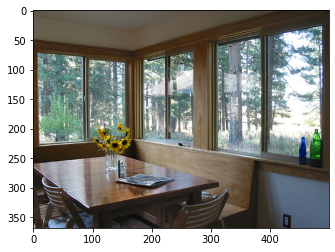

This photo captures the elegance of a well-designed dining room with a beautiful view.

VLM: This image is a:
0.1445 photo
0.1246 sketch
0.1012 painting
0.0879 cartoon

VLM: There:
0.1374 no people
0.1346 people

VLM: I think this photo was taken at a:
0.2506 indoor bow window
0.2403 dining room
0.2378 interior balcony

VLM: I think there might be a:
0.2837 double-hung window
0.2803 casement window
0.2606 sliding window
0.2555 pivoting window
0.2480 breakfast area, breakfast nook
0.2474 dining area
0.2460 storm window, storm sash
0.2449 dining room, dining-room
0.2427 bay window, bow window
0.2423 lancet window

LM generated captions ranked by VLM scores:
0.2233 This photo captures the elegance of a well-designed dining room with a beautiful view.
0.2094 "An empty room with plenty of natural light."
0.2014 A cozy spot to enjoy a meal or conversation.
0.1965 The beauty of the indoors captured in a photo.
0.1933 "The windows of the world."
0.1842 "A room with a view."
0.1713 A window int

In [13]:
# Download image.
img_url = "https://github.com/rmokady/CLIP_prefix_caption/raw/main/Images/COCO_val2014_000000165547.jpg" #@param {type:"string"}
fname = 'demo_img.png'
with open(fname, 'wb') as f:
    f.write(requests.get(img_url).content)

verbose = True #@param {type:"boolean"}

# Load image.
img = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB)
img_feats = get_img_feats(img)
plt.imshow(img); plt.show()

# Zero-shot VLM: classify image type.
img_types = ['photo', 'cartoon', 'sketch', 'painting']
img_types_feats = get_text_feats([f'This is a {t}.' for t in img_types])
sorted_img_types, img_type_scores = get_nn_text(img_types, img_types_feats, img_feats)
img_type = sorted_img_types[0]

# Zero-shot VLM: classify number of people.
ppl_texts = ['no people', 'people']
ppl_feats = get_text_feats([f'There are {p} in this photo.' for p in ppl_texts])
sorted_ppl_texts, ppl_scores = get_nn_text(ppl_texts, ppl_feats, img_feats)
ppl_result = sorted_ppl_texts[0]
if ppl_result == 'people':
  ppl_texts = ['is one person', 'are two people', 'are three people', 'are several people', 'are many people']
  ppl_feats = get_text_feats([f'There {p} in this photo.' for p in ppl_texts])
  sorted_ppl_texts, ppl_scores = get_nn_text(ppl_texts, ppl_feats, img_feats)
  ppl_result = sorted_ppl_texts[0]
else:
  ppl_result = f'are {ppl_result}'

# Zero-shot VLM: classify places.
place_topk = 3
place_feats = get_text_feats([f'Photo of a {p}.' for p in place_texts ])
sorted_places, places_scores = get_nn_text(place_texts, place_feats, img_feats)

# Zero-shot VLM: classify objects.
obj_topk = 10
sorted_obj_texts, obj_scores = get_nn_text(object_texts, object_feats, img_feats)
object_list = ''
for i in range(obj_topk):
  object_list += f'{sorted_obj_texts[i]}, '
object_list = object_list[:-2]

# Zero-shot LM: generate captions.
num_captions = 10
prompt = f'''I am an intelligent image captioning bot.
This image is a {img_type}. There {ppl_result}.
I think this photo was taken at a {sorted_places[0]}, {sorted_places[1]}, or {sorted_places[2]}.
I think there might be a {object_list} in this {img_type}.
A creative short caption I can generate to describe this image is:'''
caption_texts = [prompt_llm(prompt, temperature=0.9) for _ in range(num_captions)]

# Zero-shot VLM: rank captions.
caption_feats = get_text_feats(caption_texts)
sorted_captions, caption_scores = get_nn_text(caption_texts, caption_feats, img_feats)
print(f'{sorted_captions[0]}\n')

if verbose:
  print(f'VLM: This image is a:')
  for img_type, score in zip(sorted_img_types, img_type_scores):
    print(f'{score:.4f} {img_type}')

  print(f'\nVLM: There:')
  for ppl_text, score in zip(sorted_ppl_texts, ppl_scores):
    print(f'{score:.4f} {ppl_text}')

  print(f'\nVLM: I think this photo was taken at a:')
  for place, score in zip(sorted_places[:place_topk], places_scores[:place_topk]):
    print(f'{score:.4f} {place}')

  print(f'\nVLM: I think there might be a:')
  for obj_text, score in zip(sorted_obj_texts[:obj_topk], obj_scores[:obj_topk]):
    print(f'{score:.4f} {obj_text}')

  print(f'\nLM generated captions ranked by VLM scores:')
  for caption, score in zip(sorted_captions, caption_scores):
    print(f'{score:.4f} {caption}')